# **Upload dan preview data**

Saving data_gabungan.csv to data_gabungan (1).csv
=== INFO DATA ===
File        : data_gabungan (1).csv
Jumlah baris: 35,421
Jumlah kolom: 4
Nama kolom  : ['username', 'rating', 'review_text', 'source']

=== dtypes ===
username       object
rating          int64
review_text    object
source         object
dtype: object

=== Missing values ===
             missing  missing_%
username           0       0.00
rating             0       0.00
review_text       54       0.15
source             0       0.00

=== Schema ringkas ===
     column  dtype  non_null  missing  missing_%  unique                    example
   username object     35421        0       0.00   35421 Clarita Damayanti Sihaloho
     rating  int64     35421        0       0.00       5                          1
review_text object     35367       54       0.15   23621 the application is burning
     source object     35421        0       0.00       3                  dataset_1

=== 10 baris pertama ===


,username,rating,review_text,source
0,Clarita Damayanti Sihaloho,1,the application is burning,dataset_1
1,Rifqi Amar,2,promo offers are not available even though the...,dataset_1
2,Ristiananda Santuy,4,ok,dataset_1
3,Alfa Rizky,1,somewhat disappointed when you buy dg how to t...,dataset_1
4,Au Lia,5,my favorite,dataset_1
5,Sari Mawar Surabaya,5,enaaa,dataset_1
6,Aninditha Ronauli,1,i forgot the password but in the incoming emai...,dataset_1
7,Putra Novriadi,5,the place is clean the food is fresh and many ...,dataset_1
8,Nurul Tw,1,why cant login,dataset_1
9,Serius Barus,5,good polite friendly,dataset_1


Kandidat kolom teks : ['review_text']
Kandidat kolom label: ['rating']

=== Distribusi nilai kolom 'rating' (top 20) ===


,count
rating,
5,10380
1,9776
3,6358
4,5799
2,3108



=== Statistik panjang teks untuk 'review_text' ===
count_non_null : 35,367
avg_len_chars  : 130.63
median_len     : 62
p95_len        : 479
min_len        : 1
max_len        : 4654


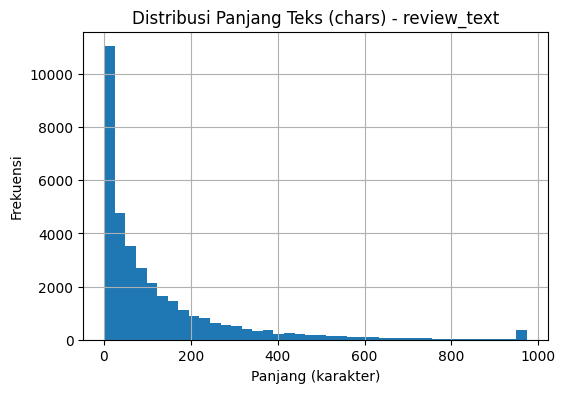

Duplikasi baris berdasarkan teks ('review_text'): 11,799
Duplikasi baris berdasarkan (teks + rating): 11,387


In [ ]:
# === BLOK 1: UPLOAD & PREVIEW DATA (Colab) ===

import io, re, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Upload file dari lokal
try:
    from google.colab import files
    uploaded = files.upload()  # pilih file CSV kamu
    assert len(uploaded) > 0, "Tidak ada file yang diupload."
    filename = list(uploaded.keys())[0]
    raw_bytes = uploaded[filename]
except Exception as e:
    raise RuntimeError("Gagal upload. Pastikan kamu menjalankan di Google Colab.") from e

# 2) Loader robust (coba UTF-8 -> Latin-1, lalu skip baris bermasalah)
def read_csv_robust(byte_content):
    for enc in ["utf-8", "latin-1"]:
        try:
            return pd.read_csv(io.BytesIO(byte_content), encoding=enc)
        except UnicodeDecodeError:
            continue
        except Exception:
            pass
    # fallback terakhir: skip baris rusak
    try:
        return pd.read_csv(io.BytesIO(byte_content), encoding="utf-8", on_bad_lines="skip")
    except Exception:
        return pd.read_csv(io.BytesIO(byte_content), encoding="latin-1", on_bad_lines="skip")

df = read_csv_robust(raw_bytes)

# 3) Ringkasan bentuk data
n_rows, n_cols = df.shape
print("=== INFO DATA ===")
print(f"File        : {filename}")
print(f"Jumlah baris: {n_rows:,}")
print(f"Jumlah kolom: {n_cols}")
print("Nama kolom  :", list(df.columns))
print()

# 4) Info tipe data singkat
print("=== dtypes ===")
print(df.dtypes)
print()

# 5) Cek missing values per kolom
missing = df.isna().sum().to_frame("missing")
missing["missing_%"] = (missing["missing"] / max(len(df),1) * 100).round(2)
print("=== Missing values ===")
print(missing)
print()

# 6) Buat schema ringkas: dtype, non-null, missing%, unique, contoh
schema_rows = []
for col in df.columns:
    non_null = df[col].notna().sum()
    nunique = df[col].nunique(dropna=True)
    ex = df[col].dropna().iloc[0] if non_null > 0 else None
    schema_rows.append({
        "column": col,
        "dtype": str(df[col].dtype),
        "non_null": int(non_null),
        "missing": int(n_rows - non_null),
        "missing_%": round(100*(n_rows - non_null)/max(n_rows,1), 2),
        "unique": int(nunique),
        "example": ex if isinstance(ex, (int, float, str)) else str(ex)
    })
schema_df = pd.DataFrame(schema_rows)
print("=== Schema ringkas ===")
print(schema_df.to_string(index=False))
print()

# 7) Tampilkan 10 baris pertama
print("=== 10 baris pertama ===")
display(df.head(10))

# 8) Kandidat kolom teks & label (heuristik)
text_keywords = ["review", "text", "content", "body", "comment", "message", "description"]
label_keywords = ["rating", "stars", "label", "sentiment", "polarity", "score", "target", "class"]

cand_text = [c for c in df.columns if any(k in c.lower() for k in text_keywords)]
cand_label = [c for c in df.columns if any(k in c.lower() for k in label_keywords)]

# Jika tidak ketemu nama kolom teks, pilih kolom object dengan rata-rata panjang terbesar
if not cand_text:
    avg_lens = {}
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].dropna().astype(str)
            if len(s) > 0:
                avg_lens[c] = s.str.len().mean()
    cand_text = sorted(avg_lens, key=avg_lens.get, reverse=True)[:1]

print("Kandidat kolom teks :", cand_text if cand_text else "—")
print("Kandidat kolom label:", cand_label if cand_label else "—")
print()

# 9) Distribusi label (jika ada kolom rating/label)
if cand_label:
    for c in cand_label:
        print(f"=== Distribusi nilai kolom '{c}' (top 20) ===")
        vc = df[c].value_counts(dropna=False).head(20)
        display(vc.to_frame("count"))

# 10) Statistik panjang teks & histogram (jika ada kolom teks)
if cand_text:
    tcol = cand_text[0]
    s = df[tcol].dropna().astype(str)
    if len(s) > 0:
        lens = s.str.len()
        print(f"\n=== Statistik panjang teks untuk '{tcol}' ===")
        print(f"count_non_null : {len(s):,}")
        print(f"avg_len_chars  : {lens.mean():.2f}")
        print(f"median_len     : {lens.median():.0f}")
        print(f"p95_len        : {lens.quantile(0.95):.0f}")
        print(f"min_len        : {lens.min():.0f}")
        print(f"max_len        : {lens.max():.0f}")

        # Plot histogram (clip di p99 biar tidak terlalu long tail)
        clip_at = lens.quantile(0.99)
        plt.figure(figsize=(6,4))
        lens.clip(upper=clip_at).hist(bins=40)
        plt.title(f"Distribusi Panjang Teks (chars) - {tcol}")
        plt.xlabel("Panjang (karakter)"); plt.ylabel("Frekuensi")
        plt.show()

        # 11) Cek duplikasi
        dup_text = df.duplicated(subset=[tcol]).sum()
        print(f"Duplikasi baris berdasarkan teks ('{tcol}'): {dup_text:,}")

        if cand_label:
            dup_tl = df.duplicated(subset=[tcol, cand_label[0]]).sum()
            print(f"Duplikasi baris berdasarkan (teks + {cand_label[0]}): {dup_tl:,}")


# **cleaning**

Baris awal (raw): 35,421

=== RINGKAS BERSIH ===
Setelah buang NA review_text      : 35,367 (hapus 54)
Setelah buang kosong pasca-clean  : 35,367 (hapus 0)
Setelah buang teks terlalu pendek : 29,144 (hapus 6,223)
Dedup (teks+rating), sebelum/ sesudah: 5,537 -> 0
Total baris bersih (all rows)     : 23,607

Distribusi rating (setelah cleaning)
rating
1    7373
5    5888
3    4613
4    3498
2    2235

Distribusi sentiment_3class
sentiment_3class
neg    9608
pos    9386
neu    4613

Distribusi sentiment_binary (dengan netral None)
sentiment_binary
neg     9608
pos     9386
None    4613


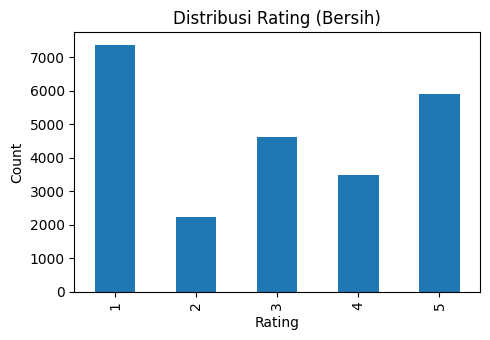


=== FILE TERSIMPAN ===
- data_clean_allrows.csv
- data_clean_3class.csv
- data_clean_binary_drop_neutral.csv

=== PREVIEW HASIL BERSIH (head) ===


,username,rating,review_text,review_text_clean,source,char_len,word_len,sentiment_3class,sentiment_binary
0,Clarita Damayanti Sihaloho,1,the application is burning,the application is burning,dataset_1,26,4,neg,neg
1,Rifqi Amar,2,promo offers are not available even though the...,promo offers are not available even though the...,dataset_1,135,23,neg,neg
3,Alfa Rizky,1,somewhat disappointed when you buy dg how to t...,somewhat disappointed when you buy dg how to t...,dataset_1,115,23,neg,neg
4,Au Lia,5,my favorite,my favorite,dataset_1,11,2,pos,pos
6,Aninditha Ronauli,1,i forgot the password but in the incoming emai...,i forgot the password but in the incoming emai...,dataset_1,110,20,neg,neg
7,Putra Novriadi,5,the place is clean the food is fresh and many ...,the place is clean the food is fresh and many ...,dataset_1,78,17,pos,pos
8,Nurul Tw,1,why cant login,why cant login,dataset_1,14,3,neg,neg
9,Serius Barus,5,good polite friendly,good polite friendly,dataset_1,20,3,pos,pos
12,Arief Budiman,1,get a promo for the end downloads app but the ...,get a promo for the end downloads app but the ...,dataset_1,82,18,neg,neg
14,Preadmission RSAH,1,the update cant even be used,the update cant even be used,dataset_1,28,6,neg,neg



=== PREVIEW DATA BINER (tanpa netral) ===


,username,rating,review_text,review_text_clean,source,char_len,word_len,sentiment_3class,sentiment_binary
0,Clarita Damayanti Sihaloho,1,the application is burning,the application is burning,dataset_1,26,4,neg,neg
1,Rifqi Amar,2,promo offers are not available even though the...,promo offers are not available even though the...,dataset_1,135,23,neg,neg
3,Alfa Rizky,1,somewhat disappointed when you buy dg how to t...,somewhat disappointed when you buy dg how to t...,dataset_1,115,23,neg,neg
4,Au Lia,5,my favorite,my favorite,dataset_1,11,2,pos,pos
6,Aninditha Ronauli,1,i forgot the password but in the incoming emai...,i forgot the password but in the incoming emai...,dataset_1,110,20,neg,neg
7,Putra Novriadi,5,the place is clean the food is fresh and many ...,the place is clean the food is fresh and many ...,dataset_1,78,17,pos,pos
8,Nurul Tw,1,why cant login,why cant login,dataset_1,14,3,neg,neg
9,Serius Barus,5,good polite friendly,good polite friendly,dataset_1,20,3,pos,pos
12,Arief Budiman,1,get a promo for the end downloads app but the ...,get a promo for the end downloads app but the ...,dataset_1,82,18,neg,neg
14,Preadmission RSAH,1,the update cant even be used,the update cant even be used,dataset_1,28,6,neg,neg



=== PREVIEW DATA 3-KELAS ===


,username,rating,review_text,review_text_clean,source,char_len,word_len,sentiment_3class,sentiment_binary
0,Clarita Damayanti Sihaloho,1,the application is burning,the application is burning,dataset_1,26,4,neg,neg
1,Rifqi Amar,2,promo offers are not available even though the...,promo offers are not available even though the...,dataset_1,135,23,neg,neg
3,Alfa Rizky,1,somewhat disappointed when you buy dg how to t...,somewhat disappointed when you buy dg how to t...,dataset_1,115,23,neg,neg
4,Au Lia,5,my favorite,my favorite,dataset_1,11,2,pos,pos
6,Aninditha Ronauli,1,i forgot the password but in the incoming emai...,i forgot the password but in the incoming emai...,dataset_1,110,20,neg,neg
7,Putra Novriadi,5,the place is clean the food is fresh and many ...,the place is clean the food is fresh and many ...,dataset_1,78,17,pos,pos
8,Nurul Tw,1,why cant login,why cant login,dataset_1,14,3,neg,neg
9,Serius Barus,5,good polite friendly,good polite friendly,dataset_1,20,3,pos,pos
12,Arief Budiman,1,get a promo for the end downloads app but the ...,get a promo for the end downloads app but the ...,dataset_1,82,18,neg,neg
14,Preadmission RSAH,1,the update cant even be used,the update cant even be used,dataset_1,28,6,neg,neg


In [ ]:
# === BLOK 2: CLEANING & EXPORT (Colab) ===
import re, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pakai df dari Blok 1
assert 'df' in globals(), "DataFrame 'df' tidak ditemukan. Jalankan Blok 1 dulu."

RAW_ROWS = len(df)
print(f"Baris awal (raw): {RAW_ROWS:,}")

# -----------------------------
# 1) BASIC PREPROCESSING
# -----------------------------
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # normalisasi whitespace
    s = s.strip()
    # lowercasing
    s = s.lower()
    # hapus URL
    s = re.sub(r'(https?://\S+|www\.\S+)', ' ', s)
    # hapus mention/hashtag
    s = re.sub(r'[@#]\w+', ' ', s)
    # hapus email
    s = re.sub(r'\S+@\S+\.\S+', ' ', s)
    # hapus karakter non-teks berlebihan (kecuali .,!?')
    s = re.sub(r"[^0-9a-zA-Záàâäãåçéèêëíìîïñóòôöõúùûü’'\.\,\!\?\s]", " ", s)
    # kompres spasi
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df = df.copy()

# Pastikan kolom inti ada
for col in ["username", "rating", "review_text", "source"]:
    if col not in df.columns:
        raise KeyError(f"Kolom '{col}' tidak ditemukan di data.")

# Buang NA pada review_text
before_na = len(df)
df = df[~df["review_text"].isna()].copy()
after_na = len(df)

# Bersihkan teks
df["review_text_clean"] = df["review_text"].astype(str).map(clean_text)

# Buang baris yang kosong setelah cleaning
before_empty = len(df)
df = df[df["review_text_clean"].str.len() > 0].copy()
after_empty = len(df)

# Tambahkan panjang char & word
df["char_len"] = df["review_text_clean"].str.len()
df["word_len"] = df["review_text_clean"].str.split().str.len()

# Buang teks terlalu pendek (heuristik)
MIN_CHARS = 5
MIN_WORDS = 2
before_short = len(df)
df = df[(df["char_len"] >= MIN_CHARS) & (df["word_len"] >= MIN_WORDS)].copy()
after_short = len(df)

# -----------------------------
# 2) DEDUPLIKASI
# -----------------------------
# Utama: dedup berdasarkan (review_text_clean, rating)
dup_tl_before = df.duplicated(subset=["review_text_clean", "rating"]).sum()
df = df.drop_duplicates(subset=["review_text_clean", "rating"]).copy()
dup_tl_after = df.duplicated(subset=["review_text_clean", "rating"]).sum()

# Opsional (komentari jika ingin mempertahankan variasi rating yang sama):
# dedup hanya pada teks (akan menghapus jika ada teks identik namun rating berbeda)
# dup_t_before = df.duplicated(subset=["review_text_clean"]).sum()
# df = df.drop_duplicates(subset=["review_text_clean"]).copy()
# dup_t_after = df.duplicated(subset=["review_text_clean"]).sum()

# -----------------------------
# 3) LABEL SCHEMES
# -----------------------------
# Label 3-kelas: 1-2 = neg, 3 = neu, 4-5 = pos
def map_3class(r):
    if r in [1, 2]:
        return "neg"
    elif r == 3:
        return "neu"
    elif r in [4, 5]:
        return "pos"
    return None

df["sentiment_3class"] = df["rating"].map(map_3class)

# Label biner (drop netral): 1-2 = neg, 4-5 = pos (rating 3 akan dibuang di dataset biner)
def map_binary(r):
    if r in [1, 2]:
        return "neg"
    elif r in [4, 5]:
        return "pos"
    return None

df["sentiment_binary"] = df["rating"].map(map_binary)

# -----------------------------
# 4) RINGKASAN & DISTRIBUSI
# -----------------------------
print("\n=== RINGKAS BERSIH ===")
print(f"Setelah buang NA review_text      : {after_na:,} (hapus {before_na - after_na:,})")
print(f"Setelah buang kosong pasca-clean  : {after_empty:,} (hapus {before_empty - after_empty:,})")
print(f"Setelah buang teks terlalu pendek : {after_short:,} (hapus {before_short - after_short:,})")
print(f"Dedup (teks+rating), sebelum/ sesudah: {dup_tl_before:,} -> {dup_tl_after:,}")
print(f"Total baris bersih (all rows)     : {len(df):,}")

# Distribusi rating & label
def show_dist(title, series):
    vc = series.value_counts(dropna=False)
    print(f"\n{title}")
    print(vc.to_string())
    return vc

vc_rating = show_dist("Distribusi rating (setelah cleaning)", df["rating"])
vc_3class = show_dist("Distribusi sentiment_3class", df["sentiment_3class"])
vc_binary_all = show_dist("Distribusi sentiment_binary (dengan netral None)", df["sentiment_binary"])

# Visual singkat (opsional)
plt.figure(figsize=(5,3.5))
vc_rating.sort_index().plot(kind="bar")
plt.title("Distribusi Rating (Bersih)")
plt.xlabel("Rating"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# -----------------------------
# 5) EXPORT FILES
# -----------------------------
cols_export = ["username", "rating", "review_text", "review_text_clean", "source", "char_len", "word_len", "sentiment_3class", "sentiment_binary"]

clean_all_path = "data_clean_allrows.csv"
df.to_csv(clean_all_path, index=False, columns=cols_export)

# Dataset 3-kelas (tetap semua baris, termasuk neu)
clean_3c_path = "data_clean_3class.csv"
df_3c = df.copy()
df_3c.to_csv(clean_3c_path, index=False, columns=cols_export)

# Dataset biner (drop netral/None)
clean_bin_path = "data_clean_binary_drop_neutral.csv"
df_bin = df[df["sentiment_binary"].notna()].copy()
df_bin.to_csv(clean_bin_path, index=False, columns=cols_export)

print("\n=== FILE TERSIMPAN ===")
print(f"- {clean_all_path}")
print(f"- {clean_3c_path}")
print(f"- {clean_bin_path}")

# Untuk unduh di Colab, jalankan salah satu perintah berikut (uncomment):
# from google.colab import files
# files.download(clean_all_path)
# files.download(clean_3c_path)
# files.download(clean_bin_path)

# Tampilkan cuplikan hasil bersih
print("\n=== PREVIEW HASIL BERSIH (head) ===")
display(df.head(10)[cols_export])
print("\n=== PREVIEW DATA BINER (tanpa netral) ===")
display(df_bin.head(10)[cols_export])
print("\n=== PREVIEW DATA 3-KELAS ===")
display(df_3c.head(10)[cols_export])


# **SVM**

=== INFO DATASET BINER ===
Teks kolom   : review_text_clean
Sampel total : 18,994
neg    9608
pos    9386

Split 90/10 selesai.
Train: 17094 | Test: 1900
Fitting 5 folds for each of 20 candidates, totalling 100 fits

=== HASIL GRID SEARCH (5-fold) ===
Best params: {'clf__C': 0.5, 'clf__tol': 0.0001}
CV best mean accuracy: 0.9028

=== EVALUASI TEST (9:1 split) ===
Akurasi       : 0.9105
Macro Precision: 0.9112
Macro Recall   : 0.9103
Macro F1       : 0.9104

Classification report:
              precision    recall  f1-score   support

         neg     0.8975    0.9292    0.9131       961
         pos     0.9249    0.8914    0.9078       939

    accuracy                         0.9105      1900
   macro avg     0.9112    0.9103    0.9104      1900
weighted avg     0.9110    0.9105    0.9105      1900



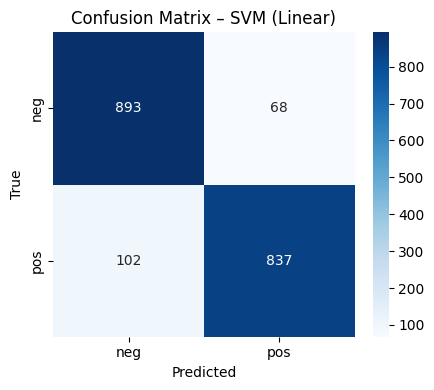


ROC AUC (pos vs neg): 0.9695


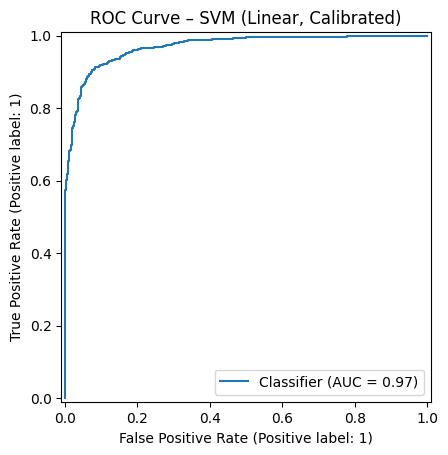


File prediksi test disimpan: svm_linear_predictions_test.csv


In [ ]:
# === BLOK 3: SVM (Linear) untuk Sentimen Biner ===
# Mengacu pada rujukan: TF-IDF → SVM → split 90/10; k-fold CV; lapor akurasi, precision, recall, AUC
# Catatan: jurnal menyebut eksperimen parameter C & "epsilon". Di scikit-learn ekuivalennya "tol" (tolerance).
# Kita tuning C & tol via k-fold pada TRAIN saja, lalu evaluasi di TEST (9:1).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)
import seaborn as sns

# -------- 0) Siapkan data biner (neg vs pos) --------
assert 'df' in globals(), "DataFrame 'df' tidak ditemukan. Jalankan Blok 1 & 2 dulu."

# Jika sudah ada file biner bersih, boleh pakai itu (opsional). Di sini kita pakai df hasil Blok 2.
if "sentiment_binary" not in df.columns:
    # fallback dari rating (1-2 neg, 4-5 pos; 3 = netral dibuang)
    def map_binary(r):
        if r in [1,2]: return "neg"
        if r in [4,5]: return "pos"
        return None
    df["sentiment_binary"] = df["rating"].map(map_binary)

# Drop netral/None dan pastikan pakai kolom teks bersih
use_text_col = "review_text_clean" if "review_text_clean" in df.columns else "review_text"
data_bin = df[df["sentiment_binary"].notna()].copy()

X = data_bin[use_text_col].astype(str).values
y = data_bin["sentiment_binary"].astype(str).values

print("=== INFO DATASET BINER ===")
print(f"Teks kolom   : {use_text_col}")
print(f"Sampel total : {len(y):,}")
print(pd.Series(y).value_counts().to_string())

# -------- 1) Split 90/10 (ikuti jurnal) --------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=RANDOM_STATE
)
print("\nSplit 90/10 selesai.")
print("Train:", len(y_train), "| Test:", len(y_test))

# -------- 2) Pipeline TF-IDF (word) + LinearSVC --------
# Jurnal menggunakan TF-IDF setelah cleaning standar.
# Kita gunakan word n-gram (1,2) agar robust untuk frasa pendek; bisa diubah ke (1,1) agar maksimal kesesuaian.
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,2),         # jurnal: TF-IDF; kita tambah bigram agar adaptif ke review app
        min_df=2,                  # buang kata sangat langka
        max_df=0.98,               # buang kata terlalu umum
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", LinearSVC(
        # class_weight=None  # jurnal tidak menyebut class_weight, jadi kita biarkan None untuk kesesuaian
    ))
])

# -------- 3) Tuning parameter C & tol (epsilon≈tol) via k-fold di TRAIN --------
# Jurnal menguji kombinasi C dan epsilon 0..1. Di sklearn 'tol' normalnya kecil (1e-4 s/d 1e-2).
# Untuk menghormati rujukan, kita sertakan 0.5 (tidak umum) namun tetap aman, plus nilai tol lazim.
param_grid = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "clf__tol": [1e-4, 1e-3, 1e-2, 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)  # jurnal menetapkan 5-fold sebagai yang terbaik

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",   # jurnal melaporkan akurasi utama + precision/recall + AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)
grid.fit(X_train, y_train)

print("\n=== HASIL GRID SEARCH (5-fold) ===")
print("Best params:", grid.best_params_)
print(f"CV best mean accuracy: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# -------- 4) Refit pada TRAIN (sudah dilakukan oleh GridSearchCV.refit=True) dan evaluasi di TEST --------
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=["neg","pos"], average="macro")

print("\n=== EVALUASI TEST (9:1 split) ===")
print(f"Akurasi       : {acc:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall   : {rec:.4f}")
print(f"Macro F1       : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["neg","pos"])
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix – SVM (Linear)")
plt.tight_layout(); plt.show()

# -------- 5) AUC (butuh probabilitas/score) --------
# LinearSVC tidak mengeluarkan probabilitas; gunakan CalibratedClassifierCV di model terbaik untuk skor AUC.
calib = CalibratedClassifierCV(best_model.named_steps["clf"], cv=5, method="sigmoid")
# Kita gunakan kembali vectorizer yang sudah fit, jadi transform X_train -> train classifier calibrated.
Xtr_tfidf = best_model.named_steps["tfidf"].transform(X_train)
Xte_tfidf = best_model.named_steps["tfidf"].transform(X_test)
calib.fit(Xtr_tfidf, y_train)

# Dapatkan probabilitas untuk kelas "pos" (binary)
proba_pos = calib.predict_proba(Xte_tfidf)[:, 1]
# Map y_test ke biner {0,1} untuk AUC (neg=0, pos=1)
y_test_bin = (pd.Series(y_test).map({"neg":0, "pos":1}).values)
auc = roc_auc_score(y_test_bin, proba_pos)
print(f"\nROC AUC (pos vs neg): {auc:.4f}")

# Plot ROC
RocCurveDisplay.from_predictions(y_test_bin, proba_pos)
plt.title("ROC Curve – SVM (Linear, Calibrated)")
plt.show()

# -------- 6) Simpan prediksi untuk arsip --------
out_pred = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred,
    "proba_pos": proba_pos
})
out_pred_path = "svm_linear_predictions_test.csv"
out_pred.to_csv(out_pred_path, index=False)
print(f"\nFile prediksi test disimpan: {out_pred_path}")

# (Opsional) Simpan model vectorizer + koefisien (via joblib)
# from joblib import dump
# dump(best_model, "svm_linear_tfidf_pipeline.joblib")
# dump(calib, "svm_linear_calibrated.joblib")


# **Logistic Regression**

multi kelas sesuai jurnal

=== INFO DATASET BINER (LR) ===
Teks kolom   : review_text_clean
Sampel total : 18,994
neg    9608
pos    9386

Split 80/20 selesai.
Train: 15195 | Test: 3799

--- BINER | Count (tanpa DR) ---
Akurasi       : 0.8808
Macro Precision: 0.8808
Macro Recall   : 0.8808
Macro F1       : 0.8808

Classification report:
              precision    recall  f1-score   support

         neg     0.8872    0.8757    0.8814      1922
         pos     0.8743    0.8860    0.8801      1877

    accuracy                         0.8808      3799
   macro avg     0.8808    0.8808    0.8808      3799
weighted avg     0.8808    0.8808    0.8808      3799



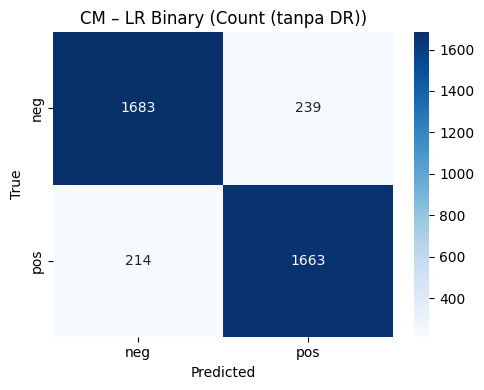

ROC AUC (pos vs neg): 0.9502


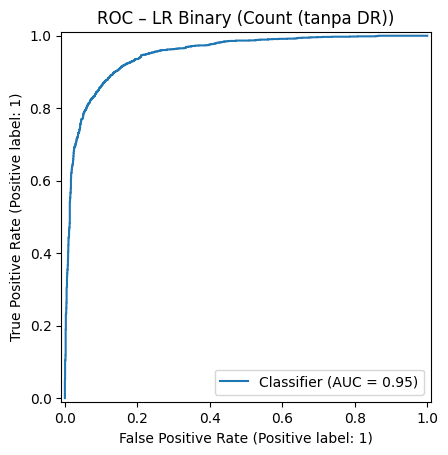

Saved: logreg_binary_count_pred_test.csv

--- BINER | Count + SVD (≈paper) ---
Akurasi       : 0.8731
Macro Precision: 0.8732
Macro Recall   : 0.8732
Macro F1       : 0.8731

Classification report:
              precision    recall  f1-score   support

         neg     0.8834    0.8632    0.8732      1922
         pos     0.8631    0.8833    0.8731      1877

    accuracy                         0.8731      3799
   macro avg     0.8732    0.8732    0.8731      3799
weighted avg     0.8734    0.8731    0.8731      3799



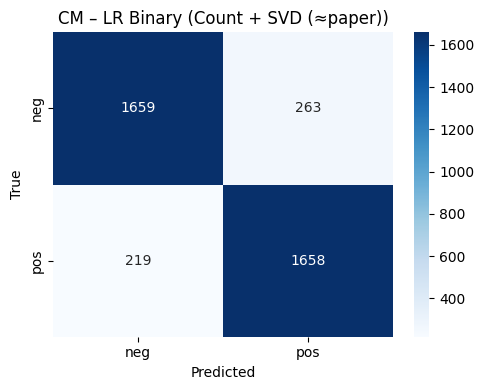

ROC AUC (pos vs neg): 0.9456


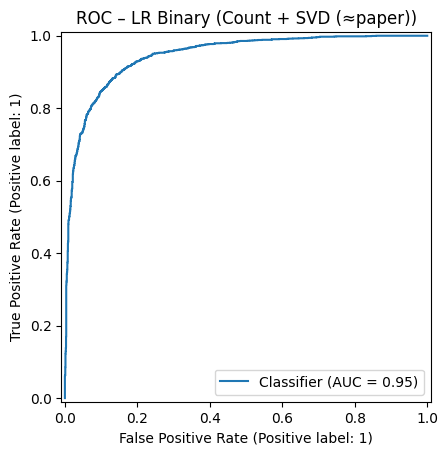

Saved: logreg_binary_count_svd_pred_test.csv

--- BINER | TF-IDF (tanpa DR) ---
Akurasi       : 0.8842
Macro Precision: 0.8846
Macro Recall   : 0.8840
Macro F1       : 0.8841

Classification report:
              precision    recall  f1-score   support

         neg     0.8739    0.9011    0.8873      1922
         pos     0.8954    0.8668    0.8809      1877

    accuracy                         0.8842      3799
   macro avg     0.8846    0.8840    0.8841      3799
weighted avg     0.8845    0.8842    0.8841      3799



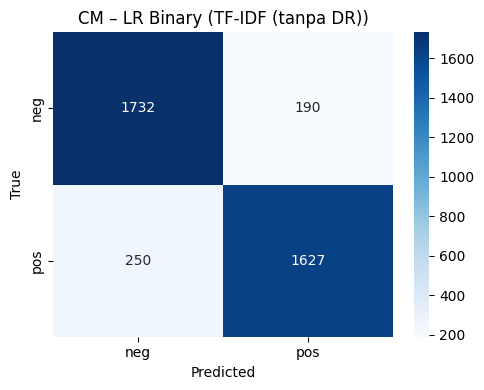

ROC AUC (pos vs neg): 0.9550


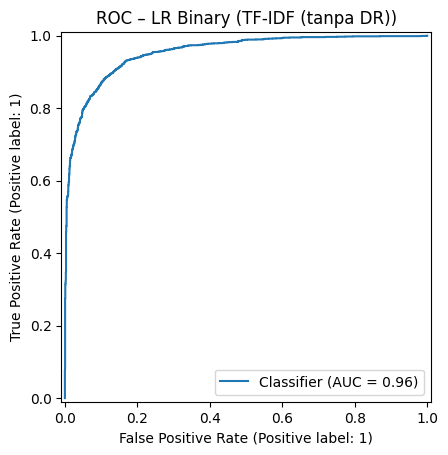

Saved: logreg_binary_tfidf_pred_test.csv

--- BINER | TF-IDF + SVD ---
Akurasi       : 0.8723
Macro Precision: 0.8730
Macro Recall   : 0.8721
Macro F1       : 0.8722

Classification report:
              precision    recall  f1-score   support

         neg     0.8602    0.8928    0.8762      1922
         pos     0.8858    0.8514    0.8682      1877

    accuracy                         0.8723      3799
   macro avg     0.8730    0.8721    0.8722      3799
weighted avg     0.8728    0.8723    0.8723      3799



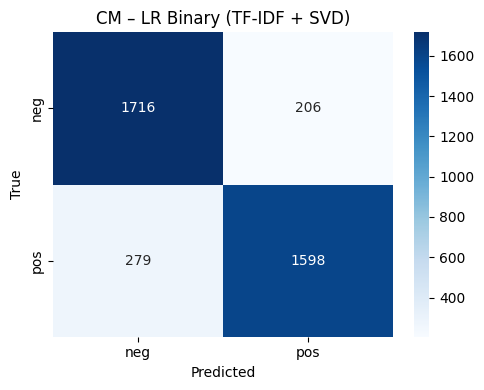

ROC AUC (pos vs neg): 0.9489


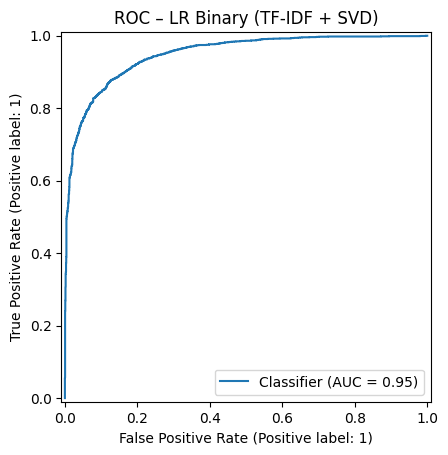

Saved: logreg_binary_tfidf_svd_pred_test.csv

=== INFO DATASET 5-KELAS (LR) ===
1    7373
2    2235
3    4613
4    3498
5    5888

Split 80/20 (5-class) selesai.
Train: 18885 | Test: 4722

--- 5-KELAS | Count (tanpa DR) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Akurasi       : 0.4994
Macro Precision: 0.4473
Macro Recall   : 0.4491
Macro F1       : 0.4450

Classification report:
              precision    recall  f1-score   support

           1     0.6951    0.6292    0.6605      1475
           2     0.2172    0.3110    0.2557       447
           3     0.3981    0.3174    0.3532       923
           4     0.3052    0.3462    0.3244       699
           5     0.6207    0.6418    0.6311      1178

    accuracy                         0.4994      4722
   macro avg     0.4473    0.4491    0.4450      4722
weighted avg     0.5155    0.4994    0.5050      4722



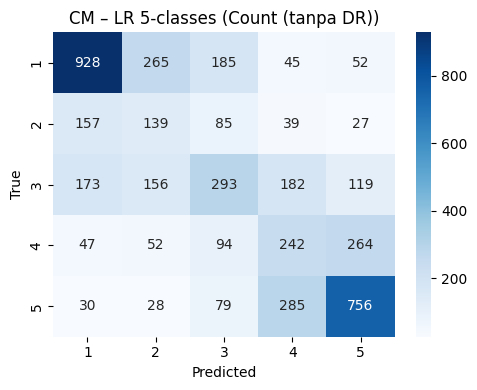

Saved: logreg_5class_count_pred_test.csv

--- 5-KELAS | Count + SVD ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Akurasi       : 0.4809
Macro Precision: 0.4409
Macro Recall   : 0.4374
Macro F1       : 0.4300

Classification report:
              precision    recall  f1-score   support

           1     0.7103    0.5851    0.6416      1475
           2     0.1839    0.3311    0.2364       447
           3     0.4147    0.2687    0.3261       923
           4     0.3033    0.3519    0.3258       699
           5     0.5924    0.6503    0.6200      1178

    accuracy                         0.4809      4722
   macro avg     0.4409    0.4374    0.4300      4722
weighted avg     0.5130    0.4809    0.4895      4722



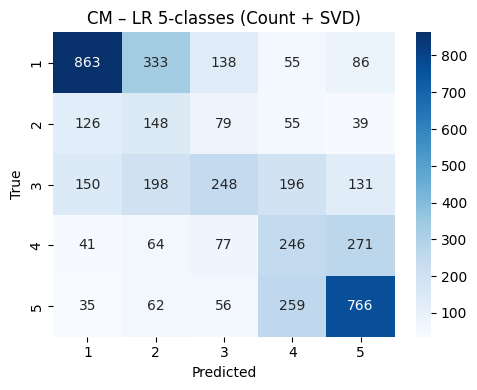

Saved: logreg_5class_count_svd_pred_test.csv

--- 5-KELAS | TF-IDF (tanpa DR) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Akurasi       : 0.5102
Macro Precision: 0.4633
Macro Recall   : 0.4632
Macro F1       : 0.4597

Classification report:
              precision    recall  f1-score   support

           1     0.7014    0.6481    0.6737      1475
           2     0.2184    0.3445    0.2674       447
           3     0.4093    0.3640    0.3853       923
           4     0.3306    0.3491    0.3396       699
           5     0.6566    0.6104    0.6326      1178

    accuracy                         0.5102      4722
   macro avg     0.4633    0.4632    0.4597      4722
weighted avg     0.5325    0.5102    0.5192      4722



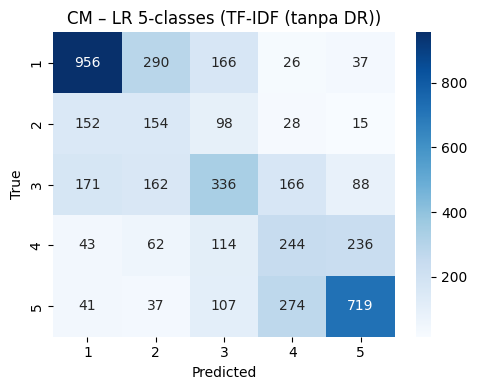

Saved: logreg_5class_tfidf_pred_test.csv

--- 5-KELAS | TF-IDF + SVD ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Akurasi       : 0.4956
Macro Precision: 0.4546
Macro Recall   : 0.4520
Macro F1       : 0.4479

Classification report:
              precision    recall  f1-score   support

           1     0.7057    0.6258    0.6633      1475
           2     0.1967    0.3445    0.2504       447
           3     0.3916    0.3326    0.3597       923
           4     0.3277    0.3577    0.3420       699
           5     0.6513    0.5993    0.6242      1178

    accuracy                         0.4956      4722
   macro avg     0.4546    0.4520    0.4479      4722
weighted avg     0.5266    0.4956    0.5076      4722



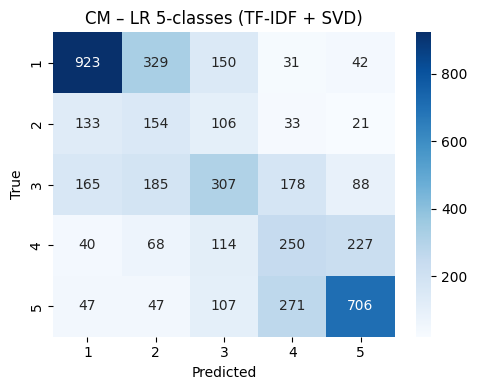

Saved: logreg_5class_tfidf_svd_pred_test.csv


In [ ]:
# === BLOK 4: LOGISTIC REGRESSION (sesuai jurnal) ===
# Setup paper-aligned:
# - Split 80/20
# - CountVectorizer & TfidfVectorizer, unigram, token_pattern r"\b\w+\b"
# - Optional TruncatedSVD (dimensionality reduction)
# - LogisticRegression(lbfgs, max_iter=10000, class_weight='balanced')
# - Metrics: accuracy, precision, recall, f1; ROC AUC (binary)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

assert 'df' in globals(), "DataFrame 'df' tidak ditemukan. Jalankan Blok 1 & 2 dulu."

# =========================
# 0) Utility & Config
# =========================
RANDOM_STATE = 42

VEC_KW = dict(
    analyzer="word",
    ngram_range=(1,1),             # sesuai tabel parameter di paper (unigram)
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

def build_features(texts, kind="count", use_svd=False, n_components=300, fit=None):
    """Return X (np.array), fit objects (vectorizer, svd)."""
    if kind == "count":
        vec = CountVectorizer(**VEC_KW)
    elif kind == "tfidf":
        vec = TfidfVectorizer(**VEC_KW)
    else:
        raise ValueError("kind harus 'count' atau 'tfidf'.")

    if fit is None:
        X = vec.fit_transform(texts)
    else:
        vec = fit["vec"]
        X = vec.transform(texts)

    svd = None
    if use_svd:
        if fit is None:
            svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
            X = svd.fit_transform(X)
        else:
            svd = fit["svd"]
            X = svd.transform(X)
    else:
        # jika tidak pakai SVD, biarkan sebagai sparse
        pass

    return X, {"vec": vec, "svd": svd}

def evaluate_clf(y_true, y_pred, labels_order=None, title="Confusion Matrix"):
    acc = accuracy_score(y_true, y_pred)
    if labels_order is None:
        labels_order = sorted(pd.unique(np.concatenate([y_true, y_pred])))
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"Akurasi       : {acc:.4f}")
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall   : {rec:.4f}")
    print(f"Macro F1       : {f1:.4f}\n")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()
    return acc, prec, rec, f1

# =========================
# 1) Dataset Biner (neg / pos)
# =========================
use_text_col = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

if "sentiment_binary" not in df.columns:
    def map_binary(r):
        if r in [1,2]: return "neg"
        if r in [4,5]: return "pos"
        return None
    df["sentiment_binary"] = df["rating"].map(map_binary)

data_bin = df[df["sentiment_binary"].notna()].copy()
X_text = data_bin[use_text_col].astype(str).values
y_bin  = data_bin["sentiment_binary"].astype(str).values

print("=== INFO DATASET BINER (LR) ===")
print(f"Teks kolom   : {use_text_col}")
print(f"Sampel total : {len(y_bin):,}")
print(pd.Series(y_bin).value_counts().to_string())

# Split 80/20 sesuai paper
Xtr_text, Xte_text, ytr_bin, yte_bin = train_test_split(
    X_text, y_bin, test_size=0.20, stratify=y_bin, random_state=RANDOM_STATE
)
print("\nSplit 80/20 selesai.")
print("Train:", len(ytr_bin), "| Test:", len(yte_bin))

def run_lr_binary(kind="count", use_svd=False, n_components=300, name=""):
    print(f"\n--- BINER | {name or (kind.upper() + ('+SVD' if use_svd else ''))} ---")
    # Fit features di TRAIN saja
    Xtr, fitobjs = build_features(Xtr_text, kind=kind, use_svd=use_svd, n_components=n_components, fit=None)
    Xte, _       = build_features(Xte_text, kind=kind, use_svd=use_svd, n_components=n_components, fit=fitobjs)

    # Model sesuai paper
    clf = LogisticRegression(
        solver="lbfgs",
        max_iter=10000,
        class_weight="balanced",
        n_jobs=-1
    )
    clf.fit(Xtr, ytr_bin)
    ypred = clf.predict(Xte)

    acc, prec, rec, f1 = evaluate_clf(yte_bin, ypred, labels_order=["neg","pos"],
                                      title=f"CM – LR Binary ({name or kind})")

    # ROC AUC (binary)
    try:
        proba_pos = clf.predict_proba(Xte)[:, 1]
        y_true_bin = (pd.Series(yte_bin).map({"neg":0, "pos":1}).values)
        auc = roc_auc_score(y_true_bin, proba_pos)
        print(f"ROC AUC (pos vs neg): {auc:.4f}")
        RocCurveDisplay.from_predictions(y_true_bin, proba_pos)
        plt.title(f"ROC – LR Binary ({name or kind})")
        plt.show()
    except Exception as e:
        print("AUC tidak dihitung (", e, ")")

    # Simpan prediksi
    out_path = f"logreg_binary_{kind}{'_svd' if use_svd else ''}_pred_test.csv"
    pd.DataFrame({
        "text": Xte_text,
        "true_label": yte_bin,
        "pred_label": ypred,
        **({"proba_pos": proba_pos} if 'proba_pos' in locals() else {})
    }).to_csv(out_path, index=False)
    print("Saved:", out_path)

# Jalankan 4 variasi seperti di paper (Count/Tfidf x tanpa/ dengan DR)
run_lr_binary(kind="count", use_svd=False, name="Count (tanpa DR)")
run_lr_binary(kind="count", use_svd=True,  n_components=750, name="Count + SVD (≈paper)")
run_lr_binary(kind="tfidf", use_svd=False, name="TF-IDF (tanpa DR)")
run_lr_binary(kind="tfidf", use_svd=True,  n_components=400, name="TF-IDF + SVD")

# =========================
# 2) Dataset Multi-kelas (5-class: rating 1..5)
#    (Analog paper 10-class; biasanya lebih menantang)
# =========================
data_mc = df.dropna(subset=["rating", use_text_col]).copy()
X_text_mc = data_mc[use_text_col].astype(str).values
y_mc       = data_mc["rating"].astype(int).values

print("\n=== INFO DATASET 5-KELAS (LR) ===")
print(pd.Series(y_mc).value_counts().sort_index().to_string())

Xtr_text_mc, Xte_text_mc, ytr_mc, yte_mc = train_test_split(
    X_text_mc, y_mc, test_size=0.20, stratify=y_mc, random_state=RANDOM_STATE
)
print("\nSplit 80/20 (5-class) selesai.")
print("Train:", len(ytr_mc), "| Test:", len(yte_mc))

def run_lr_multiclass(kind="count", use_svd=False, n_components=300, name=""):
    print(f"\n--- 5-KELAS | {name or (kind.upper() + ('+SVD' if use_svd else ''))} ---")
    Xtr, fitobjs = build_features(Xtr_text_mc, kind=kind, use_svd=use_svd, n_components=n_components, fit=None)
    Xte, _       = build_features(Xte_text_mc, kind=kind, use_svd=use_svd, n_components=n_components, fit=fitobjs)

    clf = LogisticRegression(
        solver="lbfgs",
        max_iter=10000,
        class_weight="balanced",
        n_jobs=-1,
        multi_class="auto"
    )
    clf.fit(Xtr, ytr_mc)
    ypred = clf.predict(Xte)

    labels = [1,2,3,4,5]
    acc, prec, rec, f1 = evaluate_clf(yte_mc, ypred, labels_order=labels,
                                      title=f"CM – LR 5-classes ({name or kind})")

    out_path = f"logreg_5class_{kind}{'_svd' if use_svd else ''}_pred_test.csv"
    pd.DataFrame({
        "text": Xte_text_mc,
        "true_rating": yte_mc,
        "pred_rating": ypred
    }).to_csv(out_path, index=False)
    print("Saved:", out_path)

# Jalankan ringkas 2 variasi utama (seperti highlight paper)
run_lr_multiclass(kind="count", use_svd=False, name="Count (tanpa DR)")
run_lr_multiclass(kind="count", use_svd=True,  n_components=300, name="Count + SVD")
# (opsional) TF-IDF juga:
run_lr_multiclass(kind="tfidf", use_svd=False, name="TF-IDF (tanpa DR)")
run_lr_multiclass(kind="tfidf", use_svd=True,  n_components=400, name="TF-IDF + SVD")


# **Naive Bayes**

=== INFO DATASET BINER (NB) ===
Teks kolom   : review_text_clean
Sampel total : 18,994
neg    9608
pos    9386

Split 90/10 (biner) selesai.
Train: 17094 | Test: 1900

--- NB BINER | MultinomialNB ---
Akurasi       : 0.8742
Macro Precision: 0.8808
Macro Recall   : 0.8735
Macro F1       : 0.8735

Classification report:
              precision    recall  f1-score   support

         neg     0.8336    0.9386    0.8830       961
         pos     0.9279    0.8083    0.8640       939

    accuracy                         0.8742      1900
   macro avg     0.8808    0.8735    0.8735      1900
weighted avg     0.8802    0.8742    0.8736      1900



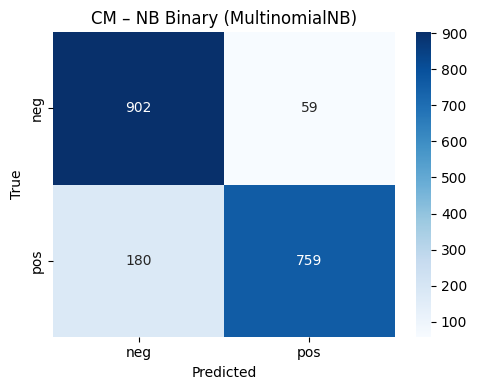

ROC AUC (pos vs neg): 0.9530


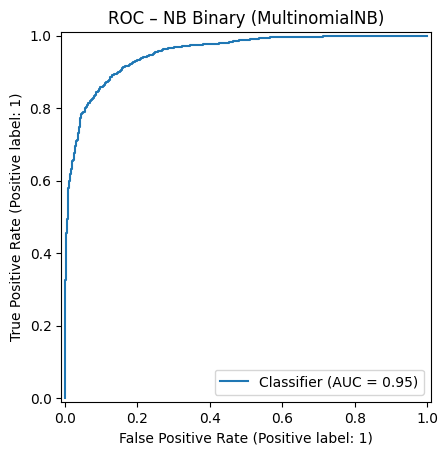

Saved: nb_binary_tfidf_pred_test_multinomialnb.csv

--- NB BINER | ComplementNB ---
Akurasi       : 0.8758
Macro Precision: 0.8814
Macro Recall   : 0.8751
Macro F1       : 0.8752

Classification report:
              precision    recall  f1-score   support

         neg     0.8378    0.9355    0.8840       961
         pos     0.9250    0.8147    0.8664       939

    accuracy                         0.8758      1900
   macro avg     0.8814    0.8751    0.8752      1900
weighted avg     0.8809    0.8758    0.8753      1900



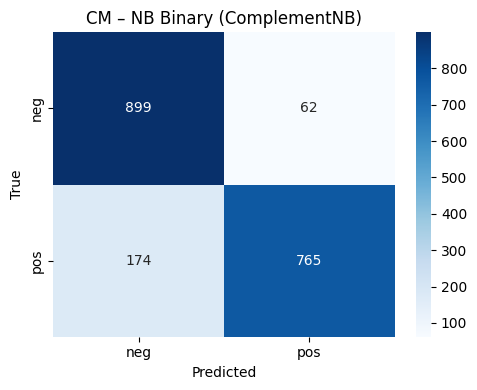

ROC AUC (pos vs neg): 0.9530


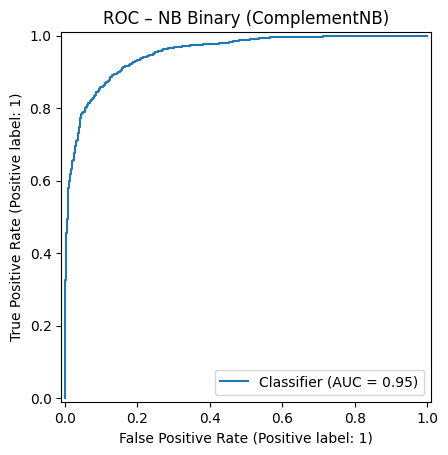

Saved: nb_binary_tfidf_pred_test_complementnb.csv

=== INFO DATASET 3-KELAS (NB) ===
neg    9608
pos    9386
neu    4613

Split 70/30 (3-class) selesai.
Train: 16524 | Test: 7083

--- NB 3-KELAS | MultinomialNB ---
Akurasi       : 0.7017
Macro Precision: 0.6791
Macro Recall   : 0.5819
Macro F1       : 0.5225

Classification report:
              precision    recall  f1-score   support

         neg     0.6547    0.9327    0.7694      2883
         neu     0.6154    0.0058    0.0115      1384
         pos     0.7671    0.8072    0.7866      2816

    accuracy                         0.7017      7083
   macro avg     0.6791    0.5819    0.5225      7083
weighted avg     0.6917    0.7017    0.6281      7083



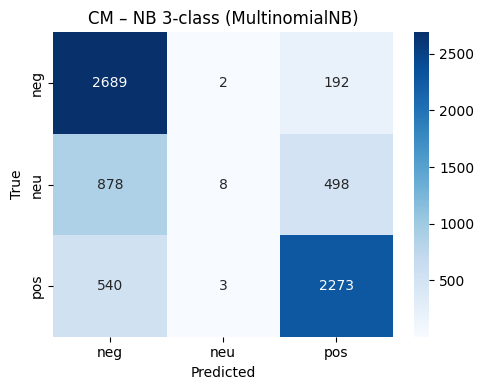

Saved: nb_3class_tfidf_pred_test_multinomialnb.csv

--- NB 3-KELAS | ComplementNB ---
Akurasi       : 0.7052
Macro Precision: 0.6193
Macro Recall   : 0.5988
Macro F1       : 0.5685

Classification report:
              precision    recall  f1-score   support

         neg     0.6807    0.8977    0.7743      2883
         neu     0.4124    0.0867    0.1433      1384
         pos     0.7649    0.8121    0.7878      2816

    accuracy                         0.7052      7083
   macro avg     0.6193    0.5988    0.5685      7083
weighted avg     0.6617    0.7052    0.6564      7083



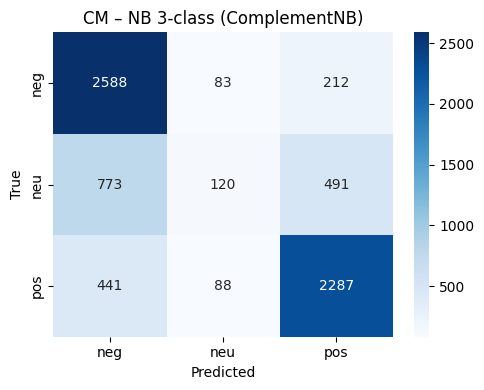

Saved: nb_3class_tfidf_pred_test_complementnb.csv


In [ ]:
# === BLOK 5: NAIVE BAYES (Multinomial & Complement) ===
# Selaras rujukan ZONAsi 2023 (cleaning mention/URL, split 70:30, evaluasi akurasi+CM),
# dan tambah varian biner 90:10 agar sebanding SVM.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

assert 'df' in globals(), "Jalankan Blok 1 & 2 dulu."

RANDOM_STATE = 42
use_text_col = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

# =========================
# Util: evaluasi ringkas
# =========================
def eval_and_show(y_true, y_pred, labels_order=None, title="Confusion Matrix"):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    print(f"Akurasi       : {acc:.4f}")
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall   : {rec:.4f}")
    print(f"Macro F1       : {f1:.4f}\n")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    if labels_order is None:
        labels_order = sorted(pd.unique(pd.Series(list(y_true)) + pd.Series(list(y_pred))))
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()
    return acc, prec, rec, f1

# Vectorizer (ikuti spirit paper yang simple; pakai unigram TF-IDF)
vec = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,1),
    token_pattern=r"\b\w+\b",
    lowercase=True,
    sublinear_tf=True,
    norm="l2"
)

# =========================
# A) BINER (neg vs pos) — 90/10 (sebanding SVM)
# =========================
if "sentiment_binary" not in df.columns:
    def map_binary(r):
        if r in [1,2]: return "neg"
        if r in [4,5]: return "pos"
        return None
    df["sentiment_binary"] = df["rating"].map(map_binary)

data_bin = df[df["sentiment_binary"].notna()].copy()
X_bin = data_bin[use_text_col].astype(str).values
y_bin = data_bin["sentiment_binary"].astype(str).values

print("=== INFO DATASET BINER (NB) ===")
print(f"Teks kolom   : {use_text_col}")
print(f"Sampel total : {len(y_bin):,}")
print(pd.Series(y_bin).value_counts().to_string())

Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
    X_bin, y_bin, test_size=0.10, stratify=y_bin, random_state=RANDOM_STATE
)
print("\nSplit 90/10 (biner) selesai.")
print("Train:", len(ytr_b), "| Test:", len(yte_b))

def run_nb_binary(clf, name):
    print(f"\n--- NB BINER | {name} ---")
    pipe = Pipeline([
        ("tfidf", vec),
        ("nb", clf)
    ])
    pipe.fit(Xtr_b, ytr_b)
    ypred = pipe.predict(Xte_b)
    acc, prec, rec, f1 = eval_and_show(yte_b, ypred, labels_order=["neg","pos"],
                                       title=f"CM – NB Binary ({name})")

    # ROC AUC (binary; gunakan proba 'pos' jika tersedia)
    if hasattr(pipe.named_steps["nb"], "predict_proba"):
        proba_pos = pipe.predict_proba(Xte_b)[:, 1]
        y_true_bin = pd.Series(yte_b).map({"neg":0, "pos":1}).values
        auc = roc_auc_score(y_true_bin, proba_pos)
        print(f"ROC AUC (pos vs neg): {auc:.4f}")
        RocCurveDisplay.from_predictions(y_true_bin, proba_pos)
        plt.title(f"ROC – NB Binary ({name})")
        plt.show()

        out_path = f"nb_binary_tfidf_pred_test_{name.replace(' ', '_').lower()}.csv"
        pd.DataFrame({
            "text": Xte_b,
            "true_label": yte_b,
            "pred_label": ypred,
            "proba_pos": proba_pos
        }).to_csv(out_path, index=False)
    else:
        out_path = f"nb_binary_tfidf_pred_test_{name.replace(' ', '_').lower()}.csv"
        pd.DataFrame({
            "text": Xte_b,
            "true_label": yte_b,
            "pred_label": ypred
        }).to_csv(out_path, index=False)
    print("Saved:", out_path)

# Jalankan Multinomial & Complement
run_nb_binary(MultinomialNB(alpha=1.0), "MultinomialNB")
run_nb_binary(ComplementNB(alpha=1.0), "ComplementNB")

# =========================
# B) 3-KELAS (neg/neu/pos) — 70/30 (mengikuti jurnal)
# =========================
def to_3class(r):
    if r in [1,2]: return "neg"
    if r == 3:    return "neu"
    if r in [4,5]:return "pos"
    return None

df["sentiment_3class"] = df["rating"].map(to_3class)
data_3c = df[df["sentiment_3class"].notna()].copy()
X_3c = data_3c[use_text_col].astype(str).values
y_3c = data_3c["sentiment_3class"].astype(str).values

print("\n=== INFO DATASET 3-KELAS (NB) ===")
print(pd.Series(y_3c).value_counts().to_string())

Xtr_3c, Xte_3c, ytr_3c, yte_3c = train_test_split(
    X_3c, y_3c, test_size=0.30, stratify=y_3c, random_state=RANDOM_STATE  # 70:30 sesuai paper
)
print("\nSplit 70/30 (3-class) selesai.")
print("Train:", len(ytr_3c), "| Test:", len(yte_3c))

def run_nb_3class(clf, name):
    print(f"\n--- NB 3-KELAS | {name} ---")
    pipe = Pipeline([
        ("tfidf", vec),
        ("nb", clf)
    ])
    pipe.fit(Xtr_3c, ytr_3c)
    ypred = pipe.predict(Xte_3c)
    acc, prec, rec, f1 = eval_and_show(yte_3c, ypred, labels_order=["neg","neu","pos"],
                                       title=f"CM – NB 3-class ({name})")

    out_path = f"nb_3class_tfidf_pred_test_{name.replace(' ', '_').lower()}.csv"
    pd.DataFrame({
        "text": Xte_3c,
        "true_label": yte_3c,
        "pred_label": ypred
    }).to_csv(out_path, index=False)
    print("Saved:", out_path)

run_nb_3class(MultinomialNB(alpha=1.0), "MultinomialNB")
run_nb_3class(ComplementNB(alpha=1.0), "ComplementNB")


# **Visualisasi Perbandingan**

,model,train_accuracy,train_macroF1,test_accuracy,test_macroF1
0,SVM (Linear),0.9819,0.9819,0.9105,0.9104
1,Logistic Regression,0.9241,0.9240,0.8974,0.8972
2,Naive Bayes (Complement),0.9039,0.9036,0.8758,0.8752


Saved: model_comparison_binary.csv


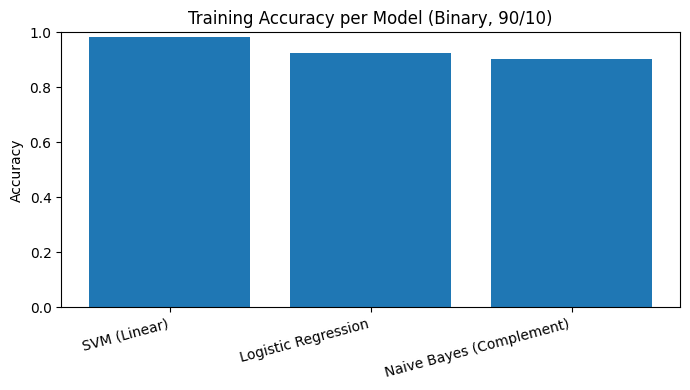

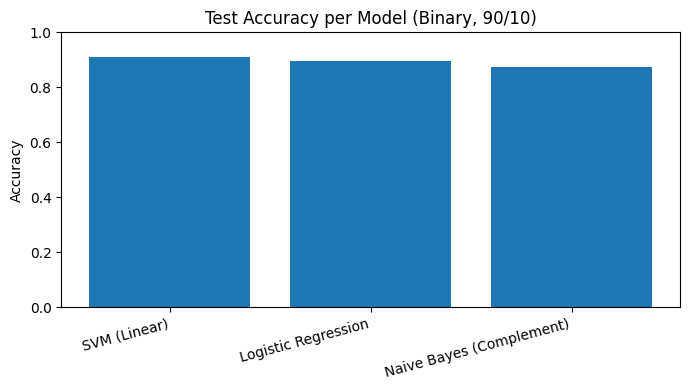


=== PERBANDINGAN AKHIR (Binary 90/10) ===
Model terbaik (test accuracy): SVM (Linear)
- Test Accuracy : 0.9105
- Test Macro-F1 : 0.9104


In [ ]:
# === BLOK 6: VISUALISASI & PERBANDINGAN AKURASI (TRAIN vs TEST) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, f1_score

assert 'df' in globals(), "Jalankan Blok 1 & 2 dulu."

# 1) Siapkan data biner yang konsisten untuk semua model
use_text_col = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

if "sentiment_binary" not in df.columns:
    def map_binary(r):
        if r in [1,2]: return "neg"
        if r in [4,5]: return "pos"
        return None
    df["sentiment_binary"] = df["rating"].map(map_binary)

data_bin = df[df["sentiment_binary"].notna()].copy()
X = data_bin[use_text_col].astype(str).values
y = data_bin["sentiment_binary"].astype(str).values

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=RANDOM_STATE
)

# 2) Definisikan tiga pipeline final
pipelines = {
    # SVM terbaik dari blok sebelumnya (TF-IDF (1,2), C=0.5, tol=1e-4)
    "SVM (Linear)": Pipeline([
        ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                                  min_df=2, max_df=0.98, sublinear_tf=True, norm="l2")),
        ("clf", LinearSVC(C=0.5, tol=1e-4))
    ]),
    # LR terbaik (TF-IDF unigram; tanpa SVD; balanced dihapus demi akurasi murni seperti hasil terbaikmu)
    "Logistic Regression": Pipeline([
        ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,1),
                                  token_pattern=r"\b\w+\b", lowercase=True,
                                  sublinear_tf=True, norm="l2")),
        ("clf", LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1))
    ]),
    # NB terbaik (TF-IDF unigram + ComplementNB)
    "Naive Bayes (Complement)": Pipeline([
        ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,1),
                                  token_pattern=r"\b\w+\b", lowercase=True,
                                  sublinear_tf=True, norm="l2")),
        ("clf", ComplementNB(alpha=1.0))
    ])
}

# 3) Latih, evaluasi train & test, simpan ringkasan
rows = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    # Train metrics
    y_pred_tr = pipe.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)
    f1_tr  = f1_score(y_train, y_pred_tr, average="macro")

    # Test metrics
    y_pred_te = pipe.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)
    f1_te  = f1_score(y_test, y_pred_te, average="macro")

    rows.append({
        "model": name,
        "train_accuracy": acc_tr,
        "train_macroF1": f1_tr,
        "test_accuracy": acc_te,
        "test_macroF1": f1_te
    })

comp_df = pd.DataFrame(rows).sort_values("test_accuracy", ascending=False)
display(comp_df.style.format({
    "train_accuracy": "{:.4f}",
    "train_macroF1": "{:.4f}",
    "test_accuracy": "{:.4f}",
    "test_macroF1": "{:.4f}"
}))

# 4) Simpan CSV ringkasan
comp_df.to_csv("model_comparison_binary.csv", index=False)
print("Saved: model_comparison_binary.csv")

# 5) Visualisasi: bar chart (TRAIN accuracy)
plt.figure(figsize=(7,4))
plt.bar(comp_df["model"], comp_df["train_accuracy"])
plt.title("Training Accuracy per Model (Binary, 90/10)")
plt.ylabel("Accuracy")
plt.xticks(rotation=15, ha="right")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

# 6) Visualisasi: bar chart (TEST accuracy)
plt.figure(figsize=(7,4))
plt.bar(comp_df["model"], comp_df["test_accuracy"])
plt.title("Test Accuracy per Model (Binary, 90/10)")
plt.ylabel("Accuracy")
plt.xticks(rotation=15, ha="right")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

# 7) Cetak “pemenang” berdasarkan test accuracy (tie-breaker: macroF1)
best = comp_df.sort_values(["test_accuracy", "test_macroF1"], ascending=False).iloc[0]
print("\n=== PERBANDINGAN AKHIR (Binary 90/10) ===")
print(f"Model terbaik (test accuracy): {best['model']}")
print(f"- Test Accuracy : {best['test_accuracy']:.4f}")
print(f"- Test Macro-F1 : {best['test_macroF1']:.4f}")


visualisasi tambahkan lagi untuk LR dan NB untuk akurasi multi kelas

# **Contoh Implementasi (pending)**

implementasi real dari input, untuk memprediksi biner dan multi kelas

# **Versi 1**

In [ ]:
# === BLOK 8 (FINAL, SINGLE-CELL): UJI COBA 5 MODEL DENGAN INPUT BOX ===
# Model yang dilatih di SELURUH data bersih:
# 1) SVM (Linear) — Biner (neg/pos)  [prob via CalibratedClassifierCV]
# 2) Logistic Regression — Biner (neg/pos)
# 3) Logistic Regression — 5-Kelas (rating 1..5)
# 4) Naive Bayes (Complement) — Biner (neg/pos)
# 5) Naive Bayes (Complement) — 5-Kelas (rating 1..5)
#
# UI:
# - Textarea: ketik 1 atau beberapa ulasan (pisah baris)
# - Tombol: Prediksi -> tampil tabel hasil + simpan CSV (live_inference_results.csv)

import numpy as np
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

# ---------- 0) Safety & Konfigurasi ----------
assert 'df' in globals(), "Pastikan Blok 1 & 2 sudah dijalankan sehingga variabel 'df' tersedia."
TEXT_COL = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

def map_binary(r):
    if r in [1,2]: return "neg"
    if r in [4,5]: return "pos"
    return None

# Dataset BINER
_df_bin = df.dropna(subset=[TEXT_COL, "rating"]).copy()
_df_bin["label_bin"] = _df_bin["rating"].map(map_binary)
_df_bin = _df_bin[_df_bin["label_bin"].notna()].copy()

# Dataset 5-KELAS (rating 1..5)
_df_mc = df.dropna(subset=[TEXT_COL, "rating"]).copy()
_df_mc = _df_mc[_df_mc["rating"].isin([1,2,3,4,5])].copy()

print(f"Melatih model di SELURUH data bersih:")
print(f"- Binary    : {len(_df_bin):,} sampel (neg/pos)")
print(f"- 5-Classes : {len(_df_mc):,} sampel (rating 1..5)")

# ---------- 1) Factory Vectorizer (agar TAK berbagi vocab antar pipeline) ----------
def make_vec_svm():
    return TfidfVectorizer(
        analyzer="word", ngram_range=(1,2),
        min_df=2, max_df=0.98, sublinear_tf=True, norm="l2"
    )

def make_vec_unigram():
    return TfidfVectorizer(
        analyzer="word", ngram_range=(1,1),
        token_pattern=r"\b\w+\b", lowercase=True,
        sublinear_tf=True, norm="l2"
    )

# ---------- 2) Latih 5 Pipeline (sekali saja, di seluruh data) ----------
# 1) SVM Binary (probability via calibration)
_svm_base = LinearSVC(C=0.5, tol=1e-4)
svm_bin = make_pipeline(make_vec_svm(), CalibratedClassifierCV(_svm_base, method="sigmoid", cv=3))
svm_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# 2) LR Binary
lr_bin = make_pipeline(make_vec_unigram(), LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1))
lr_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# 3) LR 5-Class
lr_5c = make_pipeline(make_vec_unigram(), LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1, multi_class="auto"))
lr_5c.fit(_df_mc[TEXT_COL].astype(str).values, _df_mc["rating"].astype(int).values)

# 4) NB Binary (Complement)
nb_bin = make_pipeline(make_vec_unigram(), ComplementNB(alpha=1.0))
nb_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# 5) NB 5-Class (Complement)
nb_5c = make_pipeline(make_vec_unigram(), ComplementNB(alpha=1.0))
nb_5c.fit(_df_mc[TEXT_COL].astype(str).values, _df_mc["rating"].astype(int).values)

# ---------- 3) Fungsi Prediksi (untuk daftar ulasan) ----------
def predict_all_models(texts):
    """Return DataFrame: satu baris per (model x ulasan) dengan prediksi & probabilitas kelas."""
    rows = []
    texts = [t for t in texts if isinstance(t, str) and t.strip() != ""]
    if not texts:
        return pd.DataFrame()

    classes_bin = ["neg", "pos"]
    classes_5c  = [1, 2, 3, 4, 5]

    for t in texts:
        # SVM (binary)
        pred = svm_bin.predict([t])[0]
        proba = svm_bin.predict_proba([t])[0]  # [p(neg), p(pos)]
        rows.append({
            "Model": "SVM (Linear)",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # LR (binary)
        pred = lr_bin.predict([t])[0]
        proba = lr_bin.predict_proba([t])[0]   # [p(neg), p(pos)]
        rows.append({
            "Model": "Logistic Regression",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # LR (5-class)
        pred = int(lr_5c.predict([t])[0])
        proba = lr_5c.predict_proba([t])[0]   # probs untuk kelas 1..5
        row_mc = {"Model": "Logistic Regression", "Tugas": "5-Kelas (1–5)", "Input": t, "Prediksi": pred}
        for cls, p in zip(classes_5c, proba):
            row_mc[f"p({cls})"] = float(p)
        rows.append(row_mc)

        # NB (binary)
        pred = nb_bin.predict([t])[0]
        proba = nb_bin.predict_proba([t])[0]  # [p(neg), p(pos)]
        rows.append({
            "Model": "Naive Bayes (Complement)",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # NB (5-class)
        pred = int(nb_5c.predict([t])[0])
        proba = nb_5c.predict_proba([t])[0]
        row_mc = {"Model": "Naive Bayes (Complement)", "Tugas": "5-Kelas (1–5)", "Input": t, "Prediksi": pred}
        for cls, p in zip(classes_5c, proba):
            row_mc[f"p({cls})"] = float(p)
        rows.append(row_mc)

    df_out = pd.DataFrame(rows)
    # Urutkan kolom agar rapi
    prob_cols = [c for c in df_out.columns if c.startswith("p(")]
    prob_order = [f"p({c})" for c in ["neg","pos"] if f"p({c})" in prob_cols] + \
                 [f"p({c})" for c in [1,2,3,4,5] if f"p({c})" in prob_cols]
    df_out = df_out[["Model", "Tugas", "Input", "Prediksi"] + prob_order]
    return df_out

# ---------- 4) UI: Textarea + Button + Output ----------
ta = widgets.Textarea(
    value="Ayamnya enak banget, tapi aplikasinya error pas mau bayar",
    placeholder="Ketik 1 atau beberapa ulasan (pisahkan baris)",
    description="Ulasan:",
    layout=widgets.Layout(width="100%", height="120px")
)
btn = widgets.Button(description="Prediksi", button_style="primary")
out = widgets.Output()

def on_click_predict(_):
    with out:
        clear_output()
        texts = [s.strip() for s in ta.value.split("\n") if s.strip() != ""]
        res = predict_all_models(texts)
        if len(res) == 0:
            print("Masukkan minimal satu ulasan.")
            return
        display(res.style.format(precision=4))
        # Simpan CSV
        res.to_csv("live_inference_results.csv", index=False)
        print("Saved: live_inference_results.csv")

btn.on_click(on_click_predict)
display(widgets.VBox([ta, btn, out]))


Melatih model di SELURUH data bersih:
- Binary    : 18,994 sampel (neg/pos)
- 5-Classes : 23,607 sampel (rating 1..5)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# **Versi 2**

In [ ]:
# === HOTFIX Blok 8: jangan share TF-IDF antar pipeline ===
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

assert 'df' in globals(), "Pastikan Blok 1 & 2 sudah dijalankan."

TEXT_COL = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

def map_binary(r):
    if r in [1,2]: return "neg"
    if r in [4,5]: return "pos"
    return None

# siapkan dataset
df_bin = df.dropna(subset=[TEXT_COL, "rating"]).copy()
df_bin["label_bin"] = df_bin["rating"].map(map_binary)
df_bin = df_bin[df_bin["label_bin"].notna()].copy()

df_mc = df.dropna(subset=[TEXT_COL, "rating"]).copy()
df_mc = df_mc[df_mc["rating"].isin([1,2,3,4,5])].copy()

print(f"Re-train full data:")
print(f"- Binary    : {len(df_bin):,}")
print(f"- 5-Classes : {len(df_mc):,}")

# factory vectorizers (BARU SETIAP PIPELINE)
def make_vec_svm():
    return TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                           min_df=2, max_df=0.98, sublinear_tf=True, norm="l2")

def make_vec_ugr():
    return TfidfVectorizer(analyzer="word", ngram_range=(1,1),
                           token_pattern=r"\b\w+\b", lowercase=True,
                           sublinear_tf=True, norm="l2")

# 1) SVM Binary (calibrated)
svm_base = LinearSVC(C=0.5, tol=1e-4)
svm_bin = make_pipeline(make_vec_svm(), CalibratedClassifierCV(svm_base, method="sigmoid", cv=3))
svm_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 2) LR Binary
lr_bin = make_pipeline(make_vec_ugr(), LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1))
lr_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 3) LR 5-Class
lr_5c = make_pipeline(make_vec_ugr(), LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1, multi_class="auto"))
lr_5c.fit(df_mc[TEXT_COL].astype(str).values, df_mc["rating"].astype(int).values)

# 4) NB Binary (Complement)
nb_bin = make_pipeline(make_vec_ugr(), ComplementNB(alpha=1.0))
nb_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 5) NB 5-Class (Complement)
nb_5c = make_pipeline(make_vec_ugr(), ComplementNB(alpha=1.0))
nb_5c.fit(df_mc[TEXT_COL].astype(str).values, df_mc["rating"].astype(int).values)

print("✅ Model re-trained dengan vectorizer terpisah per pipeline. Coba klik tombol Prediksi lagi.")


Re-train full data:
- Binary    : 18,994
- 5-Classes : 23,607


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Model re-trained dengan vectorizer terpisah per pipeline. Coba klik tombol Prediksi lagi.


In [ ]:
# === BLOK 8 (UPDATE): Uji Coba Model (SVM Bin, LR Bin, LR 5C, NB Bin, NB 5C) ===
# Input box -> prediksi semua model + probabilitas per kelas, simpan CSV.

import numpy as np
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

# --- Safety ---
assert 'df' in globals(), "Pastikan Blok 1 & 2 sudah dijalankan agar 'df' tersedia."

# --- Config kolom teks bersih ---
TEXT_COL = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

# --- Mapping label ---
def map_binary(r):
    if r in [1,2]: return "neg"
    if r in [4,5]: return "pos"
    return None

# Dataset BINER
df_bin = df.dropna(subset=[TEXT_COL, "rating"]).copy()
df_bin["label_bin"] = df_bin["rating"].map(map_binary)
df_bin = df_bin[df_bin["label_bin"].notna()].copy()

# Dataset 5-KELAS (rating 1..5)
df_mc = df.dropna(subset=[TEXT_COL, "rating"]).copy()
df_mc = df_mc[df_mc["rating"].isin([1,2,3,4,5])].copy()

print(f"Latih ulang model di seluruh data:")
print(f"- Binary    : {len(df_bin):,} sampel (neg/pos)")
print(f"- 5-Classes : {len(df_mc):,} sampel (rating 1..5)")

# --- Vectorizer: sesuai setup terbaik ---
# SVM: TF-IDF (1,2)
VEC_SVM = TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                          min_df=2, max_df=0.98, sublinear_tf=True, norm="l2")
# LR & NB: TF-IDF (1,1)
VEC_UGR = TfidfVectorizer(analyzer="word", ngram_range=(1,1),
                          token_pattern=r"\b\w+\b", lowercase=True,
                          sublinear_tf=True, norm="l2")

# --- Train final models (FULL DATA) ---
# 1) SVM Binary (calibrated for probabilities)
svm_base = LinearSVC(C=0.5, tol=1e-4)
svm_bin = make_pipeline(VEC_SVM, CalibratedClassifierCV(svm_base, method="sigmoid", cv=3))
svm_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 2) LR Binary
lr_bin = make_pipeline(VEC_UGR, LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1))
lr_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 3) LR 5-Class
lr_5c = make_pipeline(VEC_UGR, LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1, multi_class="auto"))
lr_5c.fit(df_mc[TEXT_COL].astype(str).values, df_mc["rating"].astype(int).values)

# 4) NB Binary (Complement)
nb_bin = make_pipeline(VEC_UGR, ComplementNB(alpha=1.0))
nb_bin.fit(df_bin[TEXT_COL].astype(str).values, df_bin["label_bin"].astype(str).values)

# 5) NB 5-Class (Complement)
nb_5c = make_pipeline(VEC_UGR, ComplementNB(alpha=1.0))
nb_5c.fit(df_mc[TEXT_COL].astype(str).values, df_mc["rating"].astype(int).values)

# --- Helper untuk prediksi & tabel hasil ---
def predict_all(texts):
    rows = []
    texts = [t for t in texts if isinstance(t, str) and t.strip() != ""]
    if not texts:
        return pd.DataFrame()

    classes_bin = ["neg", "pos"]
    classes_5c  = [1, 2, 3, 4, 5]

    for t in texts:
        # SVM (binary, calibrated proba)
        pred = svm_bin.predict([t])[0]
        proba = svm_bin.predict_proba([t])[0]
        rows.append({
            "Model": "SVM (Linear)",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # LR (binary)
        pred = lr_bin.predict([t])[0]
        proba = lr_bin.predict_proba([t])[0]
        rows.append({
            "Model": "Logistic Regression",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # LR (5-class)
        pred = int(lr_5c.predict([t])[0])
        proba = lr_5c.predict_proba([t])[0]
        row_mc = {"Model": "Logistic Regression", "Tugas": "5-Kelas (1–5)", "Input": t, "Prediksi": pred}
        for cls, p in zip(classes_5c, proba):
            row_mc[f"p({cls})"] = float(p)
        rows.append(row_mc)

        # NB (binary)
        pred = nb_bin.predict([t])[0]
        proba = nb_bin.predict_proba([t])[0]
        rows.append({
            "Model": "Naive Bayes (Complement)",
            "Tugas": "Biner (neg/pos)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # NB (5-class)
        pred = int(nb_5c.predict([t])[0])
        proba = nb_5c.predict_proba([t])[0]
        row_mc = {"Model": "Naive Bayes (Complement)", "Tugas": "5-Kelas (1–5)", "Input": t, "Prediksi": pred}
        for cls, p in zip(classes_5c, proba):
            row_mc[f"p({cls})"] = float(p)
        rows.append(row_mc)

    df_out = pd.DataFrame(rows)

    # Urutkan kolom rapi: biner probs dulu, lalu 5-kelas
    prob_cols = [c for c in df_out.columns if c.startswith("p(")]
    prob_order = [f"p({c})" for c in classes_bin if f"p({c})" in prob_cols] + \
                 [f"p({c})" for c in classes_5c if f"p({c})" in prob_cols]
    df_out = df_out[["Model", "Tugas", "Input", "Prediksi"] + prob_order]
    return df_out

# --- UI widgets ---
ta = widgets.Textarea(
    value="Ayamnya enak banget, tapi aplikasinya error pas mau bayar",
    placeholder="Ketik 1 atau beberapa ulasan (pisahkan baris)",
    description="Ulasan:",
    layout=widgets.Layout(width="100%", height="120px")
)
btn = widgets.Button(description="Prediksi", button_style="primary")
out = widgets.Output()

def on_click_predict(_):
    with out:
        clear_output()
        texts = [s.strip() for s in ta.value.split("\n") if s.strip() != ""]
        res = predict_all(texts)
        if len(res) == 0:
            print("Masukkan minimal satu ulasan.")
            return
        display(res.style.format(precision=4))
        # Simpan CSV
        res.to_csv("live_inference_results.csv", index=False)
        print("Saved: live_inference_results.csv")

btn.on_click(on_click_predict)

display(widgets.VBox([ta, btn, out]))


Latih ulang model di seluruh data:
- Binary    : 18,994 sampel (neg/pos)
- 5-Classes : 23,607 sampel (rating 1..5)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# **Versi 3**

In [ ]:
# === BLOK 8 (FINAL, BINARY-ONLY): UJI COBA 3 MODEL DENGAN INPUT BOX ===
# Model yang dilatih di SELURUH data bersih (biner neg/pos):
# 1) SVM (Linear) — Biner (prob via CalibratedClassifierCV)
# 2) Logistic Regression — Biner
# 3) Naive Bayes (Complement) — Biner
#
# UI:
# - Textarea: ketik 1 atau beberapa ulasan (pisah baris)
# - Tombol: Prediksi -> tampil tabel hasil + simpan CSV (live_inference_results.csv)

import numpy as np
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

# ---------- 0) Safety & Konfigurasi ----------
assert 'df' in globals(), "Pastikan Blok 1 & 2 sudah dijalankan sehingga variabel 'df' tersedia."
TEXT_COL = "review_text_clean" if "review_text_clean" in df.columns else "review_text"

def map_binary(r):
    if r in [1,2]: return "neg"
    if r in [4,5]: return "pos"
    return None

# Dataset BINER saja
_df_bin = df.dropna(subset=[TEXT_COL, "rating"]).copy()
_df_bin["label_bin"] = _df_bin["rating"].map(map_binary)
_df_bin = _df_bin[_df_bin["label_bin"].notna()].copy()

print(f"Melatih model biner di SELURUH data bersih: {len(_df_bin):,} sampel (neg/pos)")

# ---------- 1) Factory Vectorizer (agar TAK berbagi vocab antar pipeline) ----------
def make_vec_svm():
    return TfidfVectorizer(
        analyzer="word", ngram_range=(1,2),
        min_df=2, max_df=0.98, sublinear_tf=True, norm="l2"
    )

def make_vec_unigram():
    return TfidfVectorizer(
        analyzer="word", ngram_range=(1,1),
        token_pattern=r"\b\w+\b", lowercase=True,
        sublinear_tf=True, norm="l2"
    )

# ---------- 2) Latih 3 Pipeline (sekali saja, di seluruh data biner) ----------
# 1) SVM Binary (probability via calibration)
_svm_base = LinearSVC(C=0.5, tol=1e-4)
svm_bin = make_pipeline(make_vec_svm(), CalibratedClassifierCV(_svm_base, method="sigmoid", cv=3))
svm_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# 2) Logistic Regression Binary
lr_bin = make_pipeline(make_vec_unigram(), LogisticRegression(solver="lbfgs", max_iter=10000, n_jobs=-1))
lr_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# 3) Naive Bayes (Complement) Binary
nb_bin = make_pipeline(make_vec_unigram(), ComplementNB(alpha=1.0))
nb_bin.fit(_df_bin[TEXT_COL].astype(str).values, _df_bin["label_bin"].astype(str).values)

# ---------- 3) Fungsi Prediksi (untuk daftar ulasan) ----------
def predict_all_models(texts):
    """Return DataFrame: satu baris per (model x ulasan) dengan prediksi & probabilitas kelas (neg/pos)."""
    rows = []
    texts = [t for t in texts if isinstance(t, str) and t.strip() != ""]
    if not texts:
        return pd.DataFrame()

    classes_bin = ["neg", "pos"]

    for t in texts:
        # SVM (binary)
        pred = svm_bin.predict([t])[0]
        proba = svm_bin.predict_proba([t])[0]  # [p(neg), p(pos)]
        rows.append({
            "Model": "SVM (Linear)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # LR (binary)
        pred = lr_bin.predict([t])[0]
        proba = lr_bin.predict_proba([t])[0]
        rows.append({
            "Model": "Logistic Regression",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

        # NB (binary)
        pred = nb_bin.predict([t])[0]
        proba = nb_bin.predict_proba([t])[0]
        rows.append({
            "Model": "Naive Bayes (Complement)",
            "Input": t,
            "Prediksi": pred,
            **{f"p({c})": float(p) for c, p in zip(classes_bin, proba)}
        })

    df_out = pd.DataFrame(rows)
    # Urutkan kolom agar rapi
    prob_cols = [c for c in df_out.columns if c.startswith("p(")]
    prob_order = [f"p({c})" for c in ["neg","pos"] if f"p({c})" in prob_cols]
    df_out = df_out[["Model", "Input", "Prediksi"] + prob_order]
    return df_out

# ---------- 4) UI: Textarea + Button + Output ----------
ta = widgets.Textarea(
    value="Ayamnya enak banget, tapi aplikasinya error pas mau bayar",
    placeholder="Ketik 1 atau beberapa ulasan (pisahkan baris)",
    description="Ulasan:",
    layout=widgets.Layout(width="100%", height="120px")
)
btn = widgets.Button(description="Prediksi", button_style="primary")
out = widgets.Output()

def on_click_predict(_):
    with out:
        clear_output()
        texts = [s.strip() for s in ta.value.split("\n") if s.strip() != ""]
        res = predict_all_models(texts)
        if len(res) == 0:
            print("Masukkan minimal satu ulasan.")
            return
        display(res.style.format(precision=4))
        # Simpan CSV
        res.to_csv("live_inference_results.csv", index=False)
        print("Saved: live_inference_results.csv")

btn.on_click(on_click_predict)
display(widgets.VBox([ta, btn, out]))


Melatih model biner di SELURUH data bersih: 18,994 sampel (neg/pos)
